In [ ]:
!pip install GEOparse

import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

In [ ]:
# ============================================================
# CELL 2 — Load GSE15852 + Extract Probe Matrix + Labels
# ============================================================

print("Downloading GSE15852...")
gse = GEOparse.get_GEO("GSE15852", destdir="geo_raw", silent=True)

print("\nTotal samples:", len(gse.gsms))

# ------------------------------------------
# 1. Extract probe expression matrix (GSM tables)
# ------------------------------------------
expr_data = {}

for gsm_id, gsm in gse.gsms.items():
    tbl = gsm.table

    # Detect probe & value column
    probe_col = "ID_REF" if "ID_REF" in tbl.columns else tbl.columns[0]
    value_col = "VALUE" if "VALUE" in tbl.columns else tbl.columns[-1]

    series = tbl[[probe_col, value_col]].dropna()
    series = series.set_index(probe_col)[value_col]
    expr_data[gsm_id] = pd.to_numeric(series, errors="coerce")

X_probe = pd.DataFrame(expr_data).T
X_probe.index.name = "sample"

print("\nProbe matrix shape:", X_probe.shape)

# ------------------------------------------
# 2. Extract labels from metadata
# ------------------------------------------
def get_label(gsm):
    text = " ".join([
        str(gsm.metadata.get(k, "")).lower()
        for k in ["title", "source_name_ch1", "characteristics_ch1"]
    ])
    if "normal" in text or "control" in text:
        return "normal"
    if "cancer" in text or "tumor" in text:
        return "cancer"
    return "unknown"

labels = pd.Series(
    {gsm_id: get_label(gsm) for gsm_id, gsm in gse.gsms.items()},
    name="label"
)

print("\nLabel counts BEFORE filtering:")
print(labels.value_counts())

# Keep only normal and cancer
mask = labels.isin(["normal", "cancer"])
labels = labels[mask]
X_probe = X_probe.loc[labels.index]

print("\nLabel counts AFTER filtering:")
print(labels.value_counts())
print("Final matrix after filtering:", X_probe.shape)


Total samples: 86

Probe matrix shape: (86, 22283)

Label counts BEFORE filtering:
label
normal    43
cancer    43
Name: count, dtype: int64

Label counts AFTER filtering:
label
normal    43
cancer    43
Name: count, dtype: int64
Final matrix after filtering: (86, 22283)


In [ ]:
# ============================================================
# CELL 3 — Load GPL96 Annotation + Map Probe → Gene Symbols
# ============================================================

print("Downloading GPL96 annotation...")
gpl = GEOparse.get_GEO("GPL96", destdir="geo_raw", silent=True)

# Copy annotation table
ann = gpl.table.copy()
ann.columns = [c.upper() for c in ann.columns]

# Find the gene symbol column
symbol_col = None
for c in ["GENE SYMBOL", "GENE_SYMBOL", "GENE SYMBOLS", "SYMBOL", "GENE"]:
    if c in ann.columns:
        symbol_col = c
        break

if symbol_col is None:
    raise ValueError("❌ No gene symbol column found in GPL96.")

# Clean annotation
ann = ann[["ID", symbol_col]].rename(columns={symbol_col: "GENE"})
ann["GENE"] = ann["GENE"].astype(str).str.split("///").str[0].str.strip()
ann = ann[ann["GENE"] != ""]

print("Annotation shape:", ann.shape)

# -------------------------------------------------
# MAP PROBES → GENES
# -------------------------------------------------
print("\nMapping probes → genes...")

# Only keep probes that exist in both the annotation and expression matrix
common_probes = X_probe.columns.intersection(ann["ID"])
print("Common probes:", len(common_probes))

expr = X_probe[common_probes].copy()
ann_sub = ann.set_index("ID").loc[common_probes]

# Replace probe IDs with gene names
expr.columns = ann_sub["GENE"].values

# Collapse duplicate probes → same gene (take mean)
expr_gene = expr.groupby(expr.columns, axis=1).mean()

print("Final gene matrix shape:", expr_gene.shape)

# Save for next cell
X_gene = expr_gene
y = labels.copy()

X_gene.head()

Annotation shape: (22283, 2)

Mapping probes → genes...
Common probes: 22283
Final gene matrix shape: (86, 13238)


/tmp/ipython-input-696952797.py:45: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr_gene = expr.groupby(expr.columns, axis=1).mean()


,A1CF,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3,abParts,nan
GSM398074,3439.90,1222.61,109.3910,388.3780,244.4560,118.588,86.2719,77.26885,383.36328,268.116433,...,122.6280,943.606,139.3040,628.301,428.085,228.3110,729.392000,489.862,203.6960,461.710578
GSM398075,2584.79,3087.87,76.4441,141.4440,105.5240,526.035,42.8009,65.48510,371.52556,372.198767,...,89.9230,965.564,85.5338,398.146,204.329,173.8815,305.760167,652.960,109.5680,370.341969
GSM398076,3361.87,3005.04,161.4140,190.1860,107.4720,284.390,108.5060,114.15725,246.59788,279.155433,...,126.0820,371.683,189.5360,510.370,324.085,222.6620,667.905667,373.767,80.7432,427.211219
GSM398077,2118.56,1061.79,90.6977,90.9912,101.6920,745.409,61.4932,88.17055,328.83046,412.909200,...,87.2505,2189.280,115.4960,609.595,443.859,177.8945,575.886733,699.311,68.2710,393.483498
GSM398078,1861.67,2205.56,118.3040,108.8330,86.3246,416.241,81.5386,105.39875,319.05600,391.481933,...,121.5890,699.994,176.0095,626.586,710.780,260.7545,727.927000,357.835,91.0618,447.030781


Classes: ['cancer' 'normal']

Train shape: (64, 13238)
Test  shape: (22, 13238)

Before oversampling: [32 32]
After  oversampling: [32 32]

=========== RANDOM FOREST ===========
              precision    recall  f1-score   support

      cancer       0.71      0.91      0.80        11
      normal       0.88      0.64      0.74        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22

AUC: 0.8512396694214877


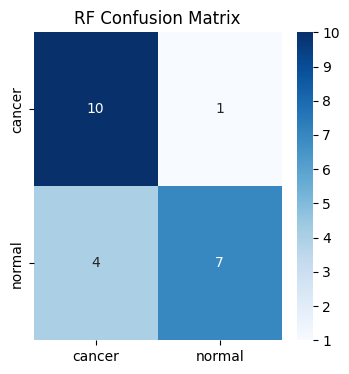


=========== MLP RESULTS ===========
              precision    recall  f1-score   support

      cancer       0.90      0.82      0.86        11
      normal       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

AUC: 0.9090909090909091


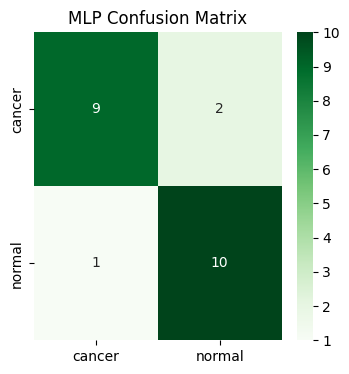

In [ ]:
# ============================================================
# CELL 4 — FULL ML PIPELINE (Scaling → RF → MLP → Metrics)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1) ENCODE LABELS
# ---------------------------------------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)

# ---------------------------------------------------------
# 2) TRAIN–TEST SPLIT (Stratified!)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_gene,
    y_enc,
    test_size=0.25,
    random_state=42,
    stratify=y_enc
)

print("\nTrain shape:", X_train.shape)
print("Test  shape:", X_test.shape)

# ---------------------------------------------------------
# 3) LOG + STANDARD SCALING
# ---------------------------------------------------------
scaler = StandardScaler()

X_train = np.log1p(X_train)
X_test  = np.log1p(X_test)

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ---------------------------------------------------------
# 4) OVERSAMPLE MINORITY CLASS
# ---------------------------------------------------------
counts = np.bincount(y_train)
maj = np.argmax(counts)
minc = 1 - maj

idx_maj = np.where(y_train == maj)[0]
idx_min = np.where(y_train == minc)[0]

n_add = len(idx_maj) - len(idx_min)
idx_add = np.random.choice(idx_min, size=n_add, replace=True)

X_train_bal = np.concatenate([X_train[idx_maj], X_train[idx_min], X_train[idx_add]], axis=0)
y_train_bal = np.concatenate([y_train[idx_maj], y_train[idx_min], y_train[idx_add]])

print("\nBefore oversampling:", counts)
print("After  oversampling:", np.bincount(y_train_bal))

# ---------------------------------------------------------
# 5) RANDOM FOREST CLASSIFIER
# ---------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=3,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_bal, y_train_bal)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("\n=========== RANDOM FOREST ===========")
print(classification_report(y_test, rf_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test, rf_proba))

# RF conf matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RF Confusion Matrix")
plt.show()

# ---------------------------------------------------------
# 6) MLP NEURAL NETWORK
# ---------------------------------------------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    alpha=1e-4,
    early_stopping=True,
    max_iter=300,
    random_state=42
)

mlp.fit(X_train_bal, y_train_bal)

mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)[:, 1]

print("\n=========== MLP RESULTS ===========")
print(classification_report(y_test, mlp_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test, mlp_proba))

# MLP conf matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, mlp_pred), annot=True, cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.show()